In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
# !pip install -r requirements.txt

# Data: CelebA

## Dataset

In [3]:
from src.modules.celeba_data_module import CelebADataset, CelebA_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels
import config_celeba
import os
import numpy as np

# download celeba dataset
dataset_gdrive_download(config = config_celeba)

# get labels map
labels_map = get_labels(config = config_celeba)

print('Number of class in label map', len(list(labels_map.keys())) )
# print()
# print('Number of samples per person')
# for i, (k, v) in enumerate(list(labels_map.items())):
#     print(len(v))
#     if i >5:
#         break
print('\ntesting dataset')

num_classes=100

dataset = CelebADataset(labels_map, num_classes=list(range(num_classes)))
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())

Dataset already downloaded
Labels already downloaded
Number of class in label map 10177

testing dataset
nb samples 2234
nb classes in dataloader 100


 Train dataset ----------------------------




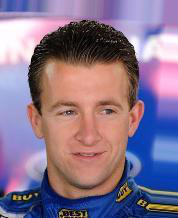

label 0
shape (178, 218)




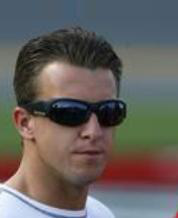

label 0
shape (178, 218)


In [4]:
#image from train dataset
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break


## Dataloader with custom sampler

In [5]:
import multiprocessing as mp
from src.modules.celeba_data_module import DATASETS

num_classes_iter = 4
batch_size = 16
dataloader = CelebA_DataModule(name=DATASETS.CELEBA, nb_classes=num_classes, class_split=True, batch_size = batch_size,
                               num_classes_iter=num_classes_iter, splitting_points=(0.10, 0.10),  
                               input_shape = (3, 256, 256), num_workers = mp.cpu_count())

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

train classes 0 90
test classes 90 100
split size 1790 198 246
Number of train batches 112
Number of valid batches 7
Number of test batches 8


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(5), tensor(5), tensor(5), tensor(5)]
[tensor(62), tensor(62), tensor(62), tensor(62)]
[tensor(29), tensor(29), tensor(29), tensor(29)]
[tensor(69), tensor(69), tensor(69), tensor(69)]


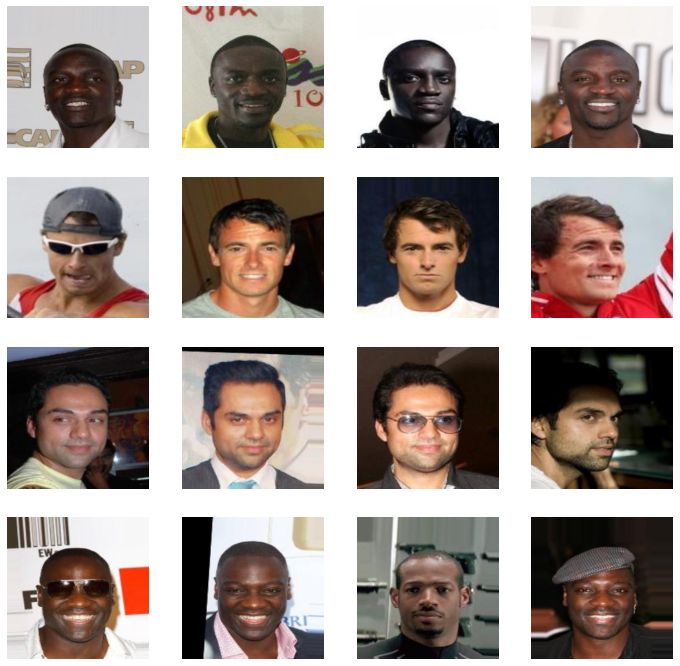

In [6]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

n_row = num_classes_iter
n_cols = int(batch_size/num_classes_iter)

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=n_row)
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(37), tensor(37), tensor(37), tensor(37)]
[tensor(17), tensor(17), tensor(17), tensor(17)]
[tensor(28), tensor(28), tensor(28), tensor(28)]
[tensor(33), tensor(33), tensor(33), tensor(33)]
[tensor(11), tensor(11), tensor(11), tensor(11)]
[tensor(7), tensor(7), tensor(7), tensor(7)]
[tensor(84), tensor(84), tensor(84), tensor(84)]
[tensor(32), tensor(32), tensor(32), tensor(32)]


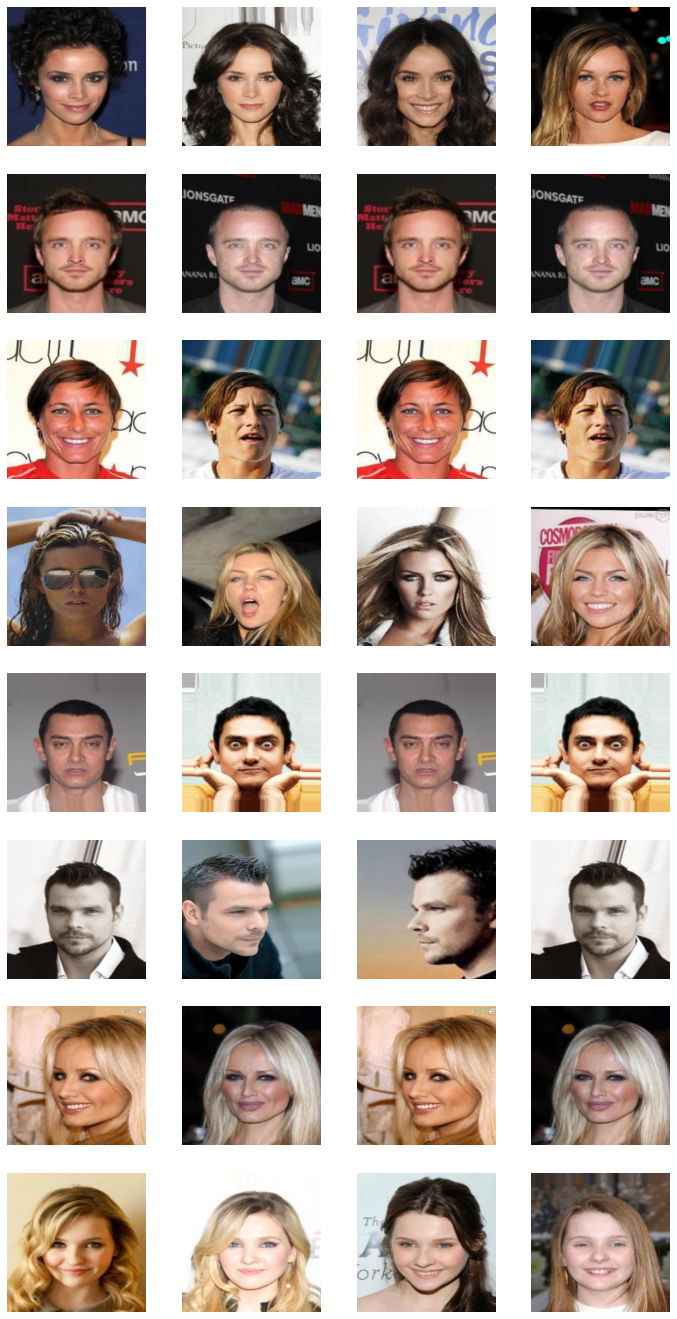

In [7]:
for i, (im, label) in enumerate(val_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(94), tensor(94), tensor(94), tensor(94)]
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(97), tensor(97), tensor(97), tensor(97)]
[tensor(99), tensor(99), tensor(99), tensor(99)]
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(95), tensor(95), tensor(95), tensor(95)]
[tensor(92), tensor(92), tensor(92), tensor(92)]


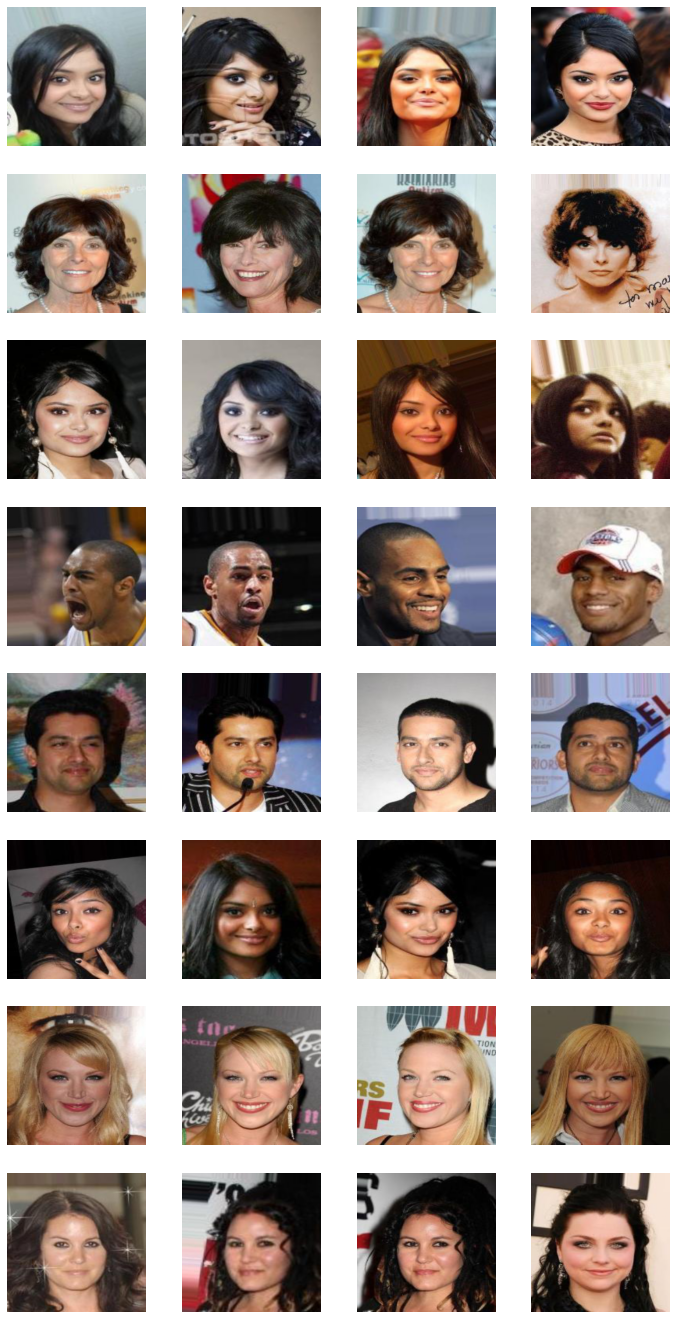

In [8]:
for i, (im, label) in enumerate(test_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

# Hyperparameter Tunning

In [9]:
do_tune = Flase
if do_tune:
    import optuna
    from src.hyper_tune import tune

    study = optuna.create_study( direction="maximize" )
    study.optimize( tune.objective, n_trials=20)

    print( "Number of finished trials: {}".format( len(study.trials) ) )

    print( "Best trial:" )
    trial = study.best_trial

    print( "  Value: {}".format( trial.value ) )

    print( "  Params: " )
    for key, value in trial.params.items():
      print( "    {}: {}".format( key, value ) )

[I 2021-01-02 18:23:08,893] A new study created in memory with name: no-name-00ffba7b-648b-4bbb-85d6-f7f17066058c


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 18:31:38,366] Trial 0 finished with value: 76.82292175292969 and parameters: {'lr': 3.320855411801885e-05, 'weight_decay': 1.691628462039664e-08, 'temp': 34, 'labels': 3}. Best is trial 0 with value: 76.82292175292969.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 18:40:13,682] Trial 1 finished with value: 82.1759262084961 and parameters: {'lr': 0.00018428279049195113, 'weight_decay': 1.1404312470575337e-05, 'temp': 20, 'labels': 2}. Best is trial 1 with value: 82.1759262084961.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 18:48:46,854] Trial 2 finished with value: 68.7789306640625 and parameters: {'lr': 0.0003754879899615515, 'weight_decay': 1.509051577221281e-08, 'temp': 47, 'labels': 4}. Best is trial 1 with value: 82.1759262084961.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 18:57:55,485] Trial 3 finished with value: 71.03588104248047 and parameters: {'lr': 1.3143523568269746e-05, 'weight_decay': 2.6206775423691904e-05, 'temp': 25, 'labels': 4}. Best is trial 1 with value: 82.1759262084961.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:06:57,485] Trial 4 finished with value: 57.29167556762695 and parameters: {'lr': 0.0006230679818315936, 'weight_decay': 1.308085062663527e-07, 'temp': 20, 'labels': 4}. Best is trial 1 with value: 82.1759262084961.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:09:05,508] Trial 5 pruned. Trial was pruned at epoch 0.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:11:12,710] Trial 6 pruned. Trial was pruned at epoch 0.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:19:59,188] Trial 7 finished with value: 81.24999237060547 and parameters: {'lr': 6.184755714890602e-05, 'weight_decay': 3.128860714067228e-06, 'temp': 22, 'labels': 3}. Best is trial 1 with value: 82.1759262084961.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:23:44,754] Trial 8 pruned. Trial was pruned at epoch 1.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:25:47,628] Trial 9 pruned. Trial was pruned at epoch 0.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:34:43,487] Trial 10 finished with value: 83.18865203857422 and parameters: {'lr': 0.0001787420257485516, 'weight_decay': 5.19618046496591e-05, 'temp': 15, 'labels': 2}. Best is trial 10 with value: 83.18865203857422.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:43:44,962] Trial 11 finished with value: 85.50347900390625 and parameters: {'lr': 0.00016024034406334994, 'weight_decay': 8.465428774480512e-05, 'temp': 12, 'labels': 2}. Best is trial 11 with value: 85.50347900390625.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 19:53:02,729] Trial 12 finished with value: 85.098388671875 and parameters: {'lr': 0.00014285165330622267, 'weight_decay': 9.696372862969888e-05, 'temp': 10, 'labels': 2}. Best is trial 11 with value: 85.50347900390625.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:02:17,546] Trial 13 finished with value: 85.04051208496094 and parameters: {'lr': 0.00010696901812061978, 'weight_decay': 8.095624477842912e-05, 'temp': 10, 'labels': 2}. Best is trial 11 with value: 85.50347900390625.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:11:28,484] Trial 14 finished with value: 84.95370483398438 and parameters: {'lr': 9.711167524320322e-05, 'weight_decay': 9.951168218042787e-05, 'temp': 11, 'labels': 2}. Best is trial 11 with value: 85.50347900390625.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:13:32,493] Trial 15 pruned. Trial was pruned at epoch 0.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:17:15,973] Trial 16 pruned. Trial was pruned at epoch 1.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:19:18,869] Trial 17 pruned. Trial was pruned at epoch 0.


Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:21:20,696] Trial 18 pruned. Trial was pruned at epoch 0.



Layers to update
train classes 0 800
test classes 800 1000
split size 13544 3386 4222


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M
INFO:lightning:
  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 11.3 M


[I 2021-01-02 20:29:58,116] Trial 19 pruned. Trial was pruned at epoch 4.


Number of finished trials: 20
Best trial:
  Value: 85.50347900390625
  Params: 
    lr: 0.00016024034406334994
    weight_decay: 8.465428774480512e-05
    temp: 12
    labels: 2


# Training the model

## Choosing the model

In [ ]:
from src.model.CustomModelGroupLoss import Siamese_Group, CNN_MODEL_GROUP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary

# cnn_model = CNN_MODEL_GROUP.MyCNN
cnn_model = CNN_MODEL_GROUP.BN_INCEPTION

if cnn_model == CNN_MODEL_GROUP.MyCNN:
    model_hparams = {
        "lr": 0.001,
        "weight_decay":1e-5,
        "filter_channels": 4,
        "filter_size": 3,
        "dropout": 0.00,
        "n_hidden1": 4096,
        "n_hidden2": 2048,
        'temperature': 10,
        'num_labeled_points_class': 2,
    }
    
    scheduler_params = {
        "step_size": 5,
        "gamma": 0.5,
    }
elif cnn_model == CNN_MODEL_GROUP.BN_INCEPTION:
    model_hparams = {
        "lr": 0.0002,
        "weight_decay":1e-7,
        'temperature': 10,
        'num_labeled_points_class': 2
    }
    
    scheduler_params = {
        "step_size": 10,
        "gamma": 0.5,
    }

# scheduler_params = None

num_classes = 10177
# num_classes = 1000

model = Siamese_Group(hparams=model_hparams, 
                cnn_model = cnn_model, 
                scheduler_params = scheduler_params,
                nb_classes = num_classes,
                finetune=False, 
                weights_path=None,
                     )

if torch.cuda.is_available():
    model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()

print("Model input size", model.input_size)

## Defining the Dataloader

In [ ]:
print('len dataset', len(dataset))

num_classes_iter = 8
num_elem_class = 6

batch_size = num_classes_iter*num_elem_class


dataloader = CelebA_DataModule(name=DATASETS.CELEBA, 
                               nb_classes=num_classes, 
                               class_split=True, 
                               batch_size=batch_size, 
                               num_classes_iter=num_classes_iter, 
                               splitting_points=(0.20, 0.20), 
                               input_shape = (3, model.input_size, model.input_size),
                               num_workers = mp.cpu_count(),
                               finetune = False)

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

for i, batch in enumerate(train_loader):
    x, y = batch
    print(x.shape)
    break

In [ ]:
# %tensorboard --logdir data/tb_group_logs/

## Train Custom Model

Please get the pretrained weights from https://drive.google.com/drive/folders/1tOCWXoAjKkIAvIECfQaKnZEIhl1z2ZGh?usp=sharing and place them in data/net/. for training the neural network

In [ ]:
exp_name = 'group_nll_loss_inc'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_nll_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_loss:.2f}',
    save_top_k=10,
    mode='min',
)

lr_monitor = pl.callbacks.LearningRateMonitor()

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": [
#         early_stop_callback,
#         checkpoint_callback,
        lr_monitor,
    ],
    "fast_dev_run": False,
    "max_epochs": 100,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

# logname = 'resnet_BCE'
logger = TensorBoardLogger(os.path.join('data','tb_group_logs'), name=exp_name)

do_train = False

trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

# Save/Load Checkpoint

## Manual Save

In [ ]:
import os

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved', 'inc_last')  
    checkpoint_path = os.path.join(save_dir, 'inc_nll_last.ckpt')
    trainer.save_checkpoint(checkpoint_path)

## Load Checkpoint
Download checkpoints from https://drive.google.com/drive/folders/1puXPrBrquphElXiCDuZSIbSYdRqprxG0?usp=sharing and use the checkpoints from group loss

In [ ]:
load_checkpoint = True

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
#     checkpoint_path = os.path.join('data', 'checkpoint', 'margin5', 'Siamese-Contrastive-epoch=25-val_loss=1.00.ckpt')
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=20-val_loss=4.95.ckpt')
#     checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=13-val_loss=5.85.ckpt')

    
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
#     x1, x2, label, y = inference(chkpt_model, loader=dataloader.val_dataloader())
#     visualize_torch(x1[:5])
#     visualize_torch(x2[:5])
#     print("labels", label.squeeze()[:5])
#     print("predictions", y.squeeze()[:5])

## Retrain from checkpoint

In [ ]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = pl.Trainer(**trainer_params, resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [ ]:
trainer.test(model, dataloader.val_dataloader())

### Note: Computational heavy!!!!

In [ ]:
calc_all_recall = False
calc_nmi = True

In [ ]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model.to('cuda'), dataloader=dataloader.val_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall.detach())
    if calc_nmi:
        print('nmi', nmi)

## Run test epoch

In [ ]:
trainer.test(model, dataloader.test_dataloader())

### Note: Computational heavy!!!!

In [ ]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=dataloader.test_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall)

    if calc_nmi:
        print('nmi', nmi)

# Inference and Visualization

In [ ]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn


for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.val_dataloader()):
    print(x.shape)
    for img_idx, closest_idx in enumerate(indices[:, 0]):        
        img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
        visualize_torch(img_matches, n_cols=2, n_rows=1)
        print(f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx]))
        if int(img_idx) == 5:
            break
    break


In [ ]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn


for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.test_dataloader()):
    for img_idx, closest_idx in enumerate(indices[:, 0]):        
        img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
        visualize_torch(img_matches, n_cols=2, n_rows=1)
        print(f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx]))
        if int(img_idx) == 5:
            break
    break